In [1]:
import camb
pars = camb.CAMBparams()
from scipy.special import jn, jn_zeros
from camb import model, initialpower
from scipy.interpolate import interp1d
from hankel_transform import *
from astropy.cosmology import Planck13 #use Planck15 if you can
import astropy.units as u
rc('text', usetex=False)

In [2]:
cosmo=Planck13.clone(H0=100)#we want h=1 for some comparisons

In [3]:
#Set up a new set of parameters for CAMB
kmax=30
kmin=.8e-3
k_smooth=1
nk=5000
rmin=.6
rmax=110
non_linear=1

pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.27, ombh2=0.022250, omch2=0.119800, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, r=0,As =2.14e-09)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
zb=[.27]#
pars.set_matter_power(redshifts=zb,kmax=kmax);
if non_linear==1:
    pars.NonLinear = model.NonLinear_both
else:
    pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk =results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints =nk)

In [4]:
#Setting up the Hankel Transform
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[0],n_zeros=28000,kmin=kmin)
#HT=hankel_transform(rmin=1,rmax=rmax,kmax=1,j_nu=[0,2],n_zeros=2800,kmin=1.e-2)#quick test... inaccurate

j-nu= 0  not enough zeros to cover kmin, increasing by  1000  to 29000
nr: 1047
CPU times: user 8.51 s, sys: 30.2 ms, total: 8.54 s
Wall time: 8.45 s


In [5]:
pk_taper=HT.taper(k=kh,pk=pk[0],large_k_lower=5,large_k_upper=kmax,low_k_lower=kmin,
                     low_k_upper=kmin*2)
#need atleast k=10 and k=1.e-3 to get decent wgg for 1-100 Mpc/h range.

In [6]:
b_g=1

In [7]:
r_gg,wgg=HT.projected_correlation(k_pk=kh,pk=pk[0]*b_g**2,j_nu=0)
%time r_gg,wgg_taper=HT.projected_correlation(k_pk=kh,pk=pk_taper*b_g**2,j_nu=0)

CPU times: user 38 ms, sys: 0 ns, total: 38 ms
Wall time: 38 ms


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


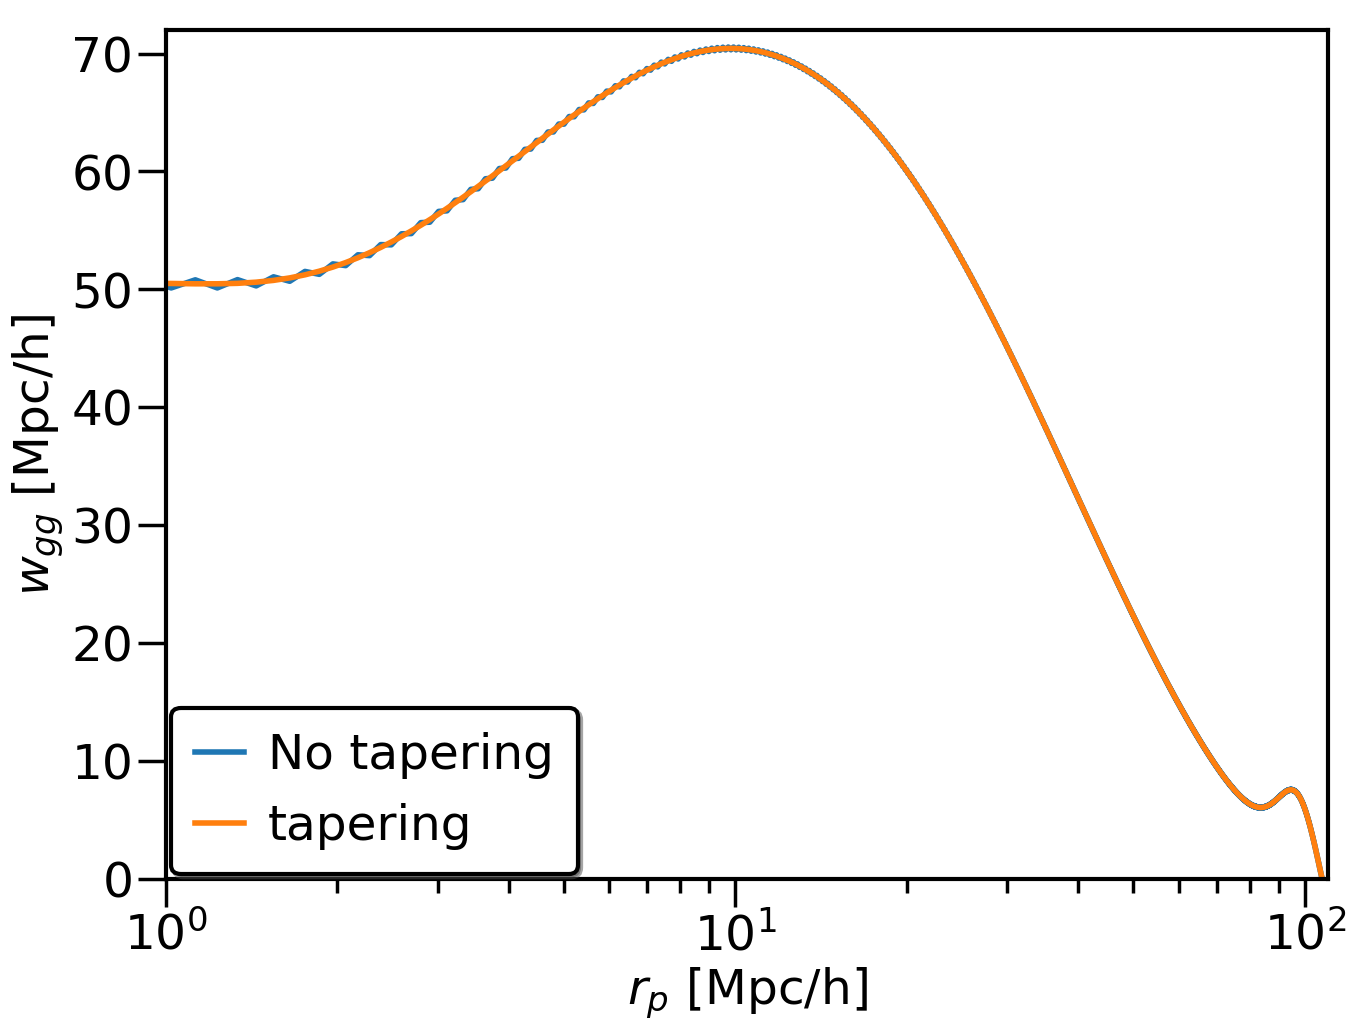

In [8]:
plot(r_gg,r_gg*wgg,label='No tapering')
plot(r_gg,r_gg*wgg_taper,label='tapering')
#plot(wgg_test['rp'],wgg_test['rp']*wgg_test['wgg']*wgg_test_fact)
xscale('log')
#yscale('log')
#ylim(1.e-2,1.e3)
xlim(1,110)
xlabel('$r_p$ [Mpc/h]')
ylabel('$w_{gg}$ [Mpc/h]')
ylim(0,72)
legend()

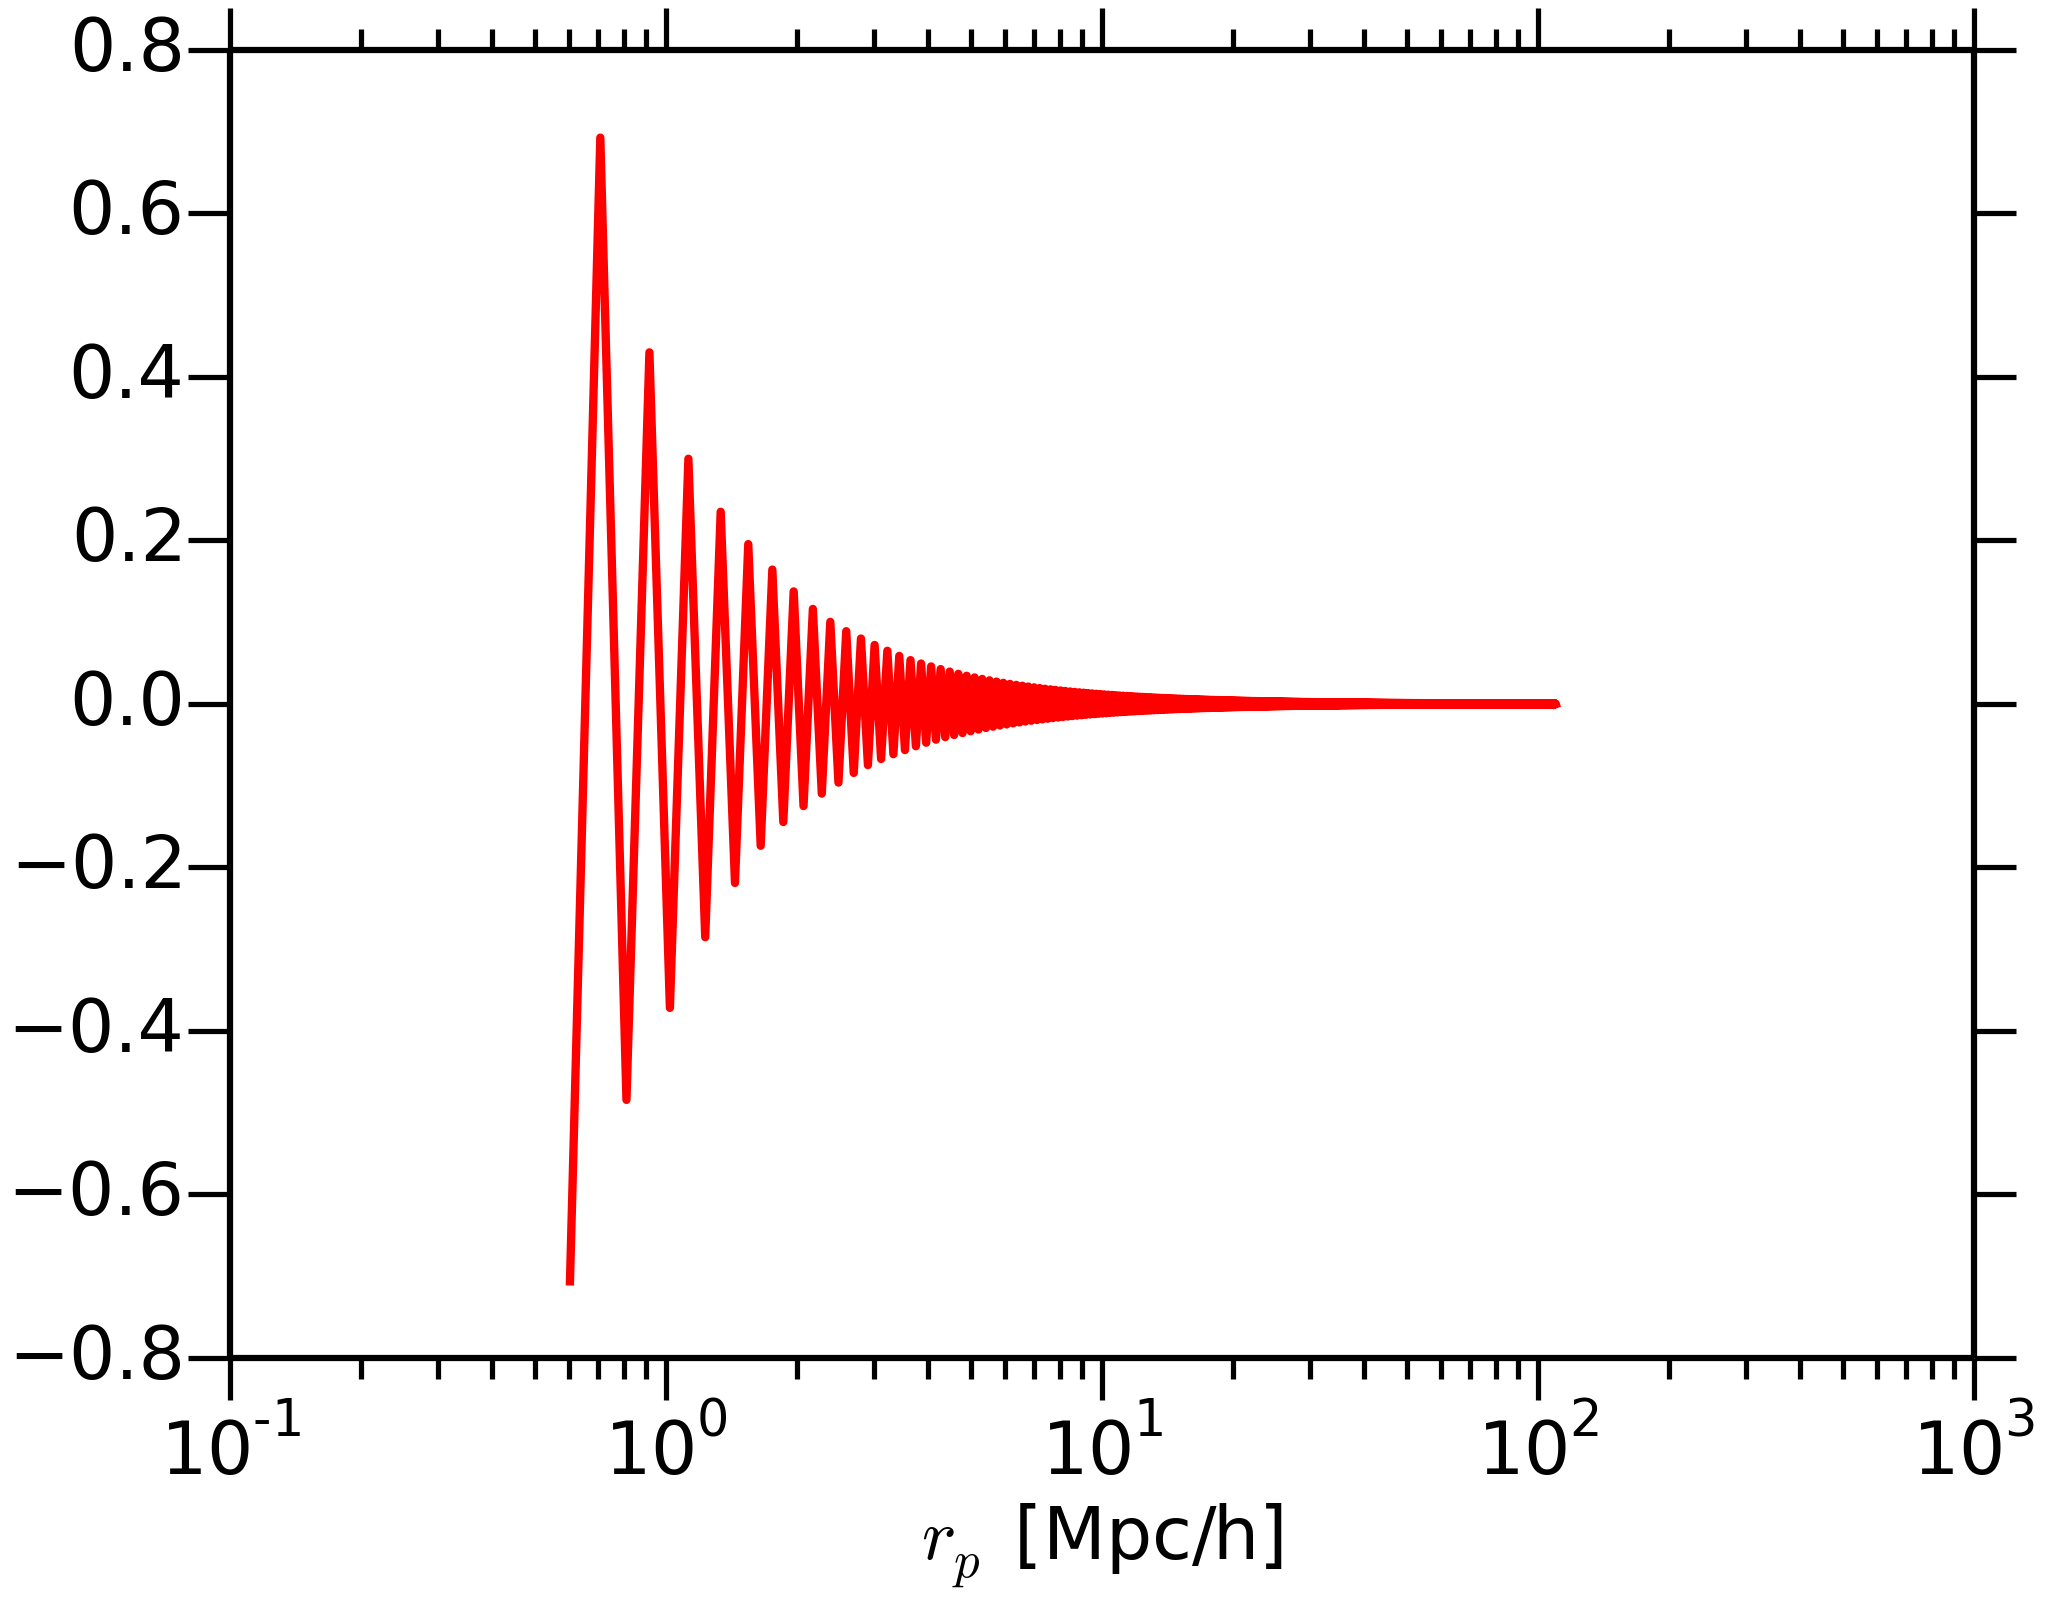

In [41]:
plot(r_gg,wgg-wgg_taper,'r')
xscale('log')
xlabel('$r_p$ [Mpc/h]')

# g-g Lensing covariance

In [13]:
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[2],n_zeros=60000,kmin=kmin)

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 61000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 62000
CPU times: user 32.7 s, sys: 882 ms, total: 33.6 s
Wall time: 34 s


In [14]:
sigma_crit=4.7e3

In [15]:
sigma_e=.36
sigma_gamma=sigma_e/1.7
n_s=8
shape_noise=sigma_crit**2*sigma_gamma**2/n_s#*cosmo.H_z(z=0.27)/cosmo.c

In [16]:
rho=0.04180594698596614 #units of Msun/pc^2/mpc, using h=1

In [17]:
Dchi2=900 #integral over product of window functions
p_kappa_kappa=pk[0]*(rho)**2*Dchi2

In [18]:
n_g=3.e-4
g_shot_noise=1./n_g
b_g=1.8
p_g=b_g**2*pk[0]
p_gk=b_g*pk[0]*rho

In [19]:
r_bins=np.logspace(-1,np.log10(110),24)

In [20]:
area=10000
area_comoving=area*(np.pi/180)**2*cosmo.comoving_distance(z=.27)**2
L_W=500
vol=area_comoving*L_W
vol=vol.value

In [21]:
taper_kw=dict({'large_k_lower':10,'large_k_upper':kmax,'low_k_lower':kmin,'low_k_upper':kmin*1.2})

In [22]:
r,cov_ggkk=HT.projected_covariance(k_pk=kh,pk1=p_g+g_shot_noise,pk2=p_kappa_kappa+shape_noise,j_nu=2,taper=True,**taper_kw)
r_re,cov_ggkk_re=HT.bin_cov(r=r,cov=cov_ggkk,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_ggkk_re)

/Users/Deep/code/python_scripts/hankel_transform.py:95: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [23]:
r,cov_gkgk=HT.projected_covariance(k_pk=kh,pk1=p_gk,pk2=p_gk,
                               kmax=100,rmin=.8,j_nu=2,rmax=110,n_zeros=3500)#return_Jrr=True,Jrr=Jrr
cov_gkgk*=Dchi2
r_re,cov_gkgk_re=HT.bin_cov(r=r,cov=cov_gkgk,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_gkgk_re)

In [24]:
cov_final=(cov_ggkk_re+cov_gkgk_re)/vol
corr=HT.corr_matrix(cov=cov_final)
errors=HT.diagonal_err(cov=cov_final)

(0.6, 110)

/Users/Deep/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


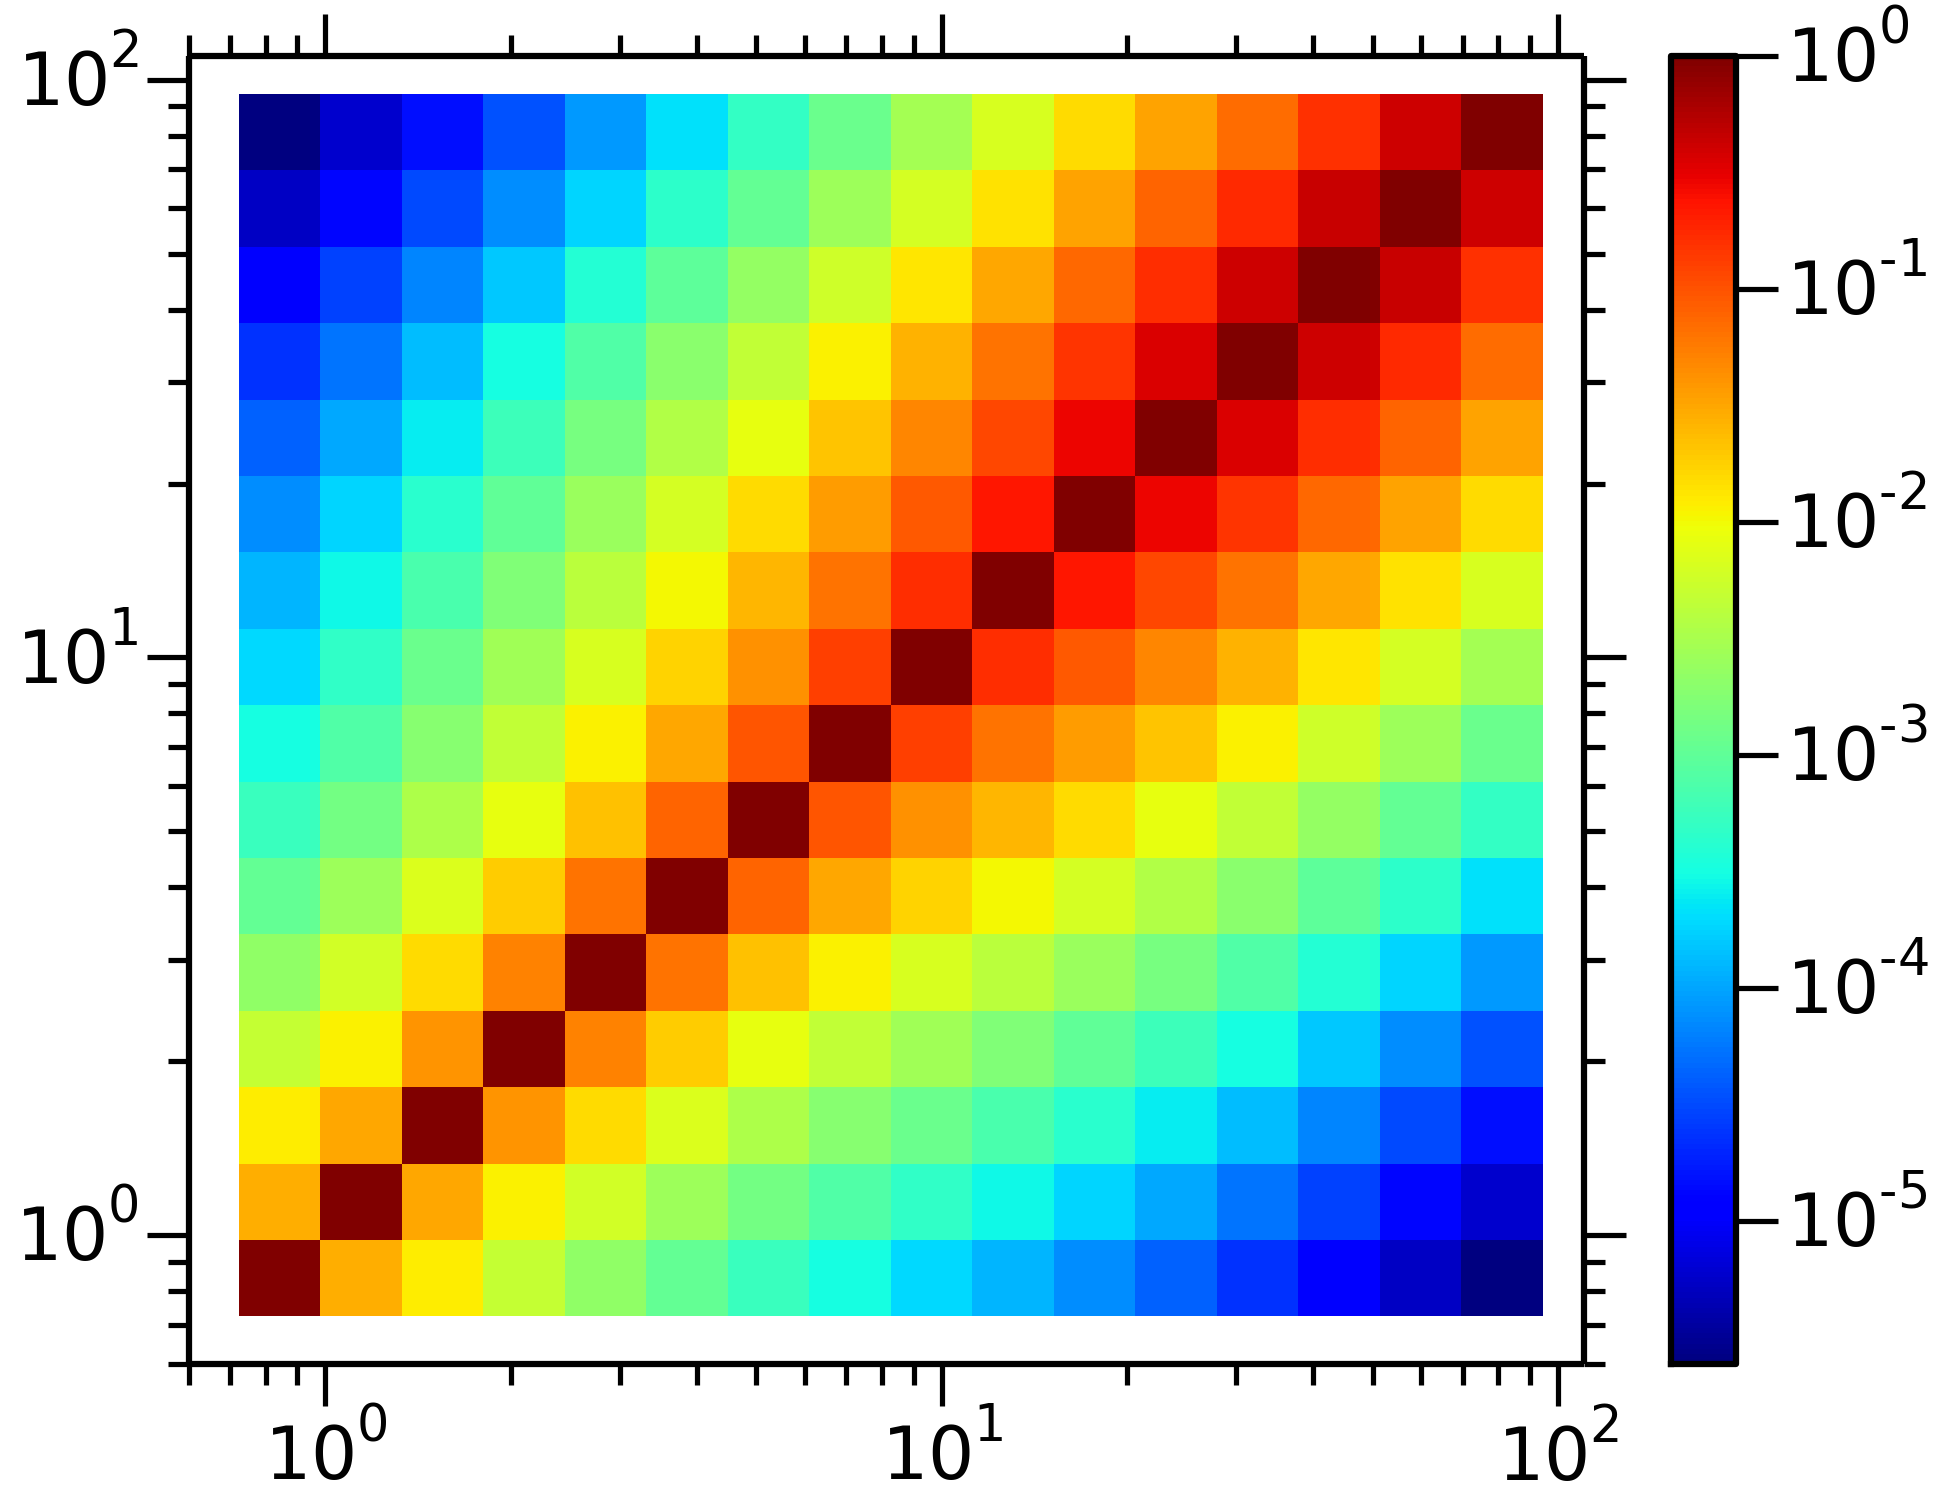

In [25]:
pcolor(r_re,r_re,corr,norm=LogNorm())
colorbar()
xscale('log')
yscale('log')
xlim(HT.rmin,HT.rmax)
ylim(HT.rmin,HT.rmax)

(1, 100)

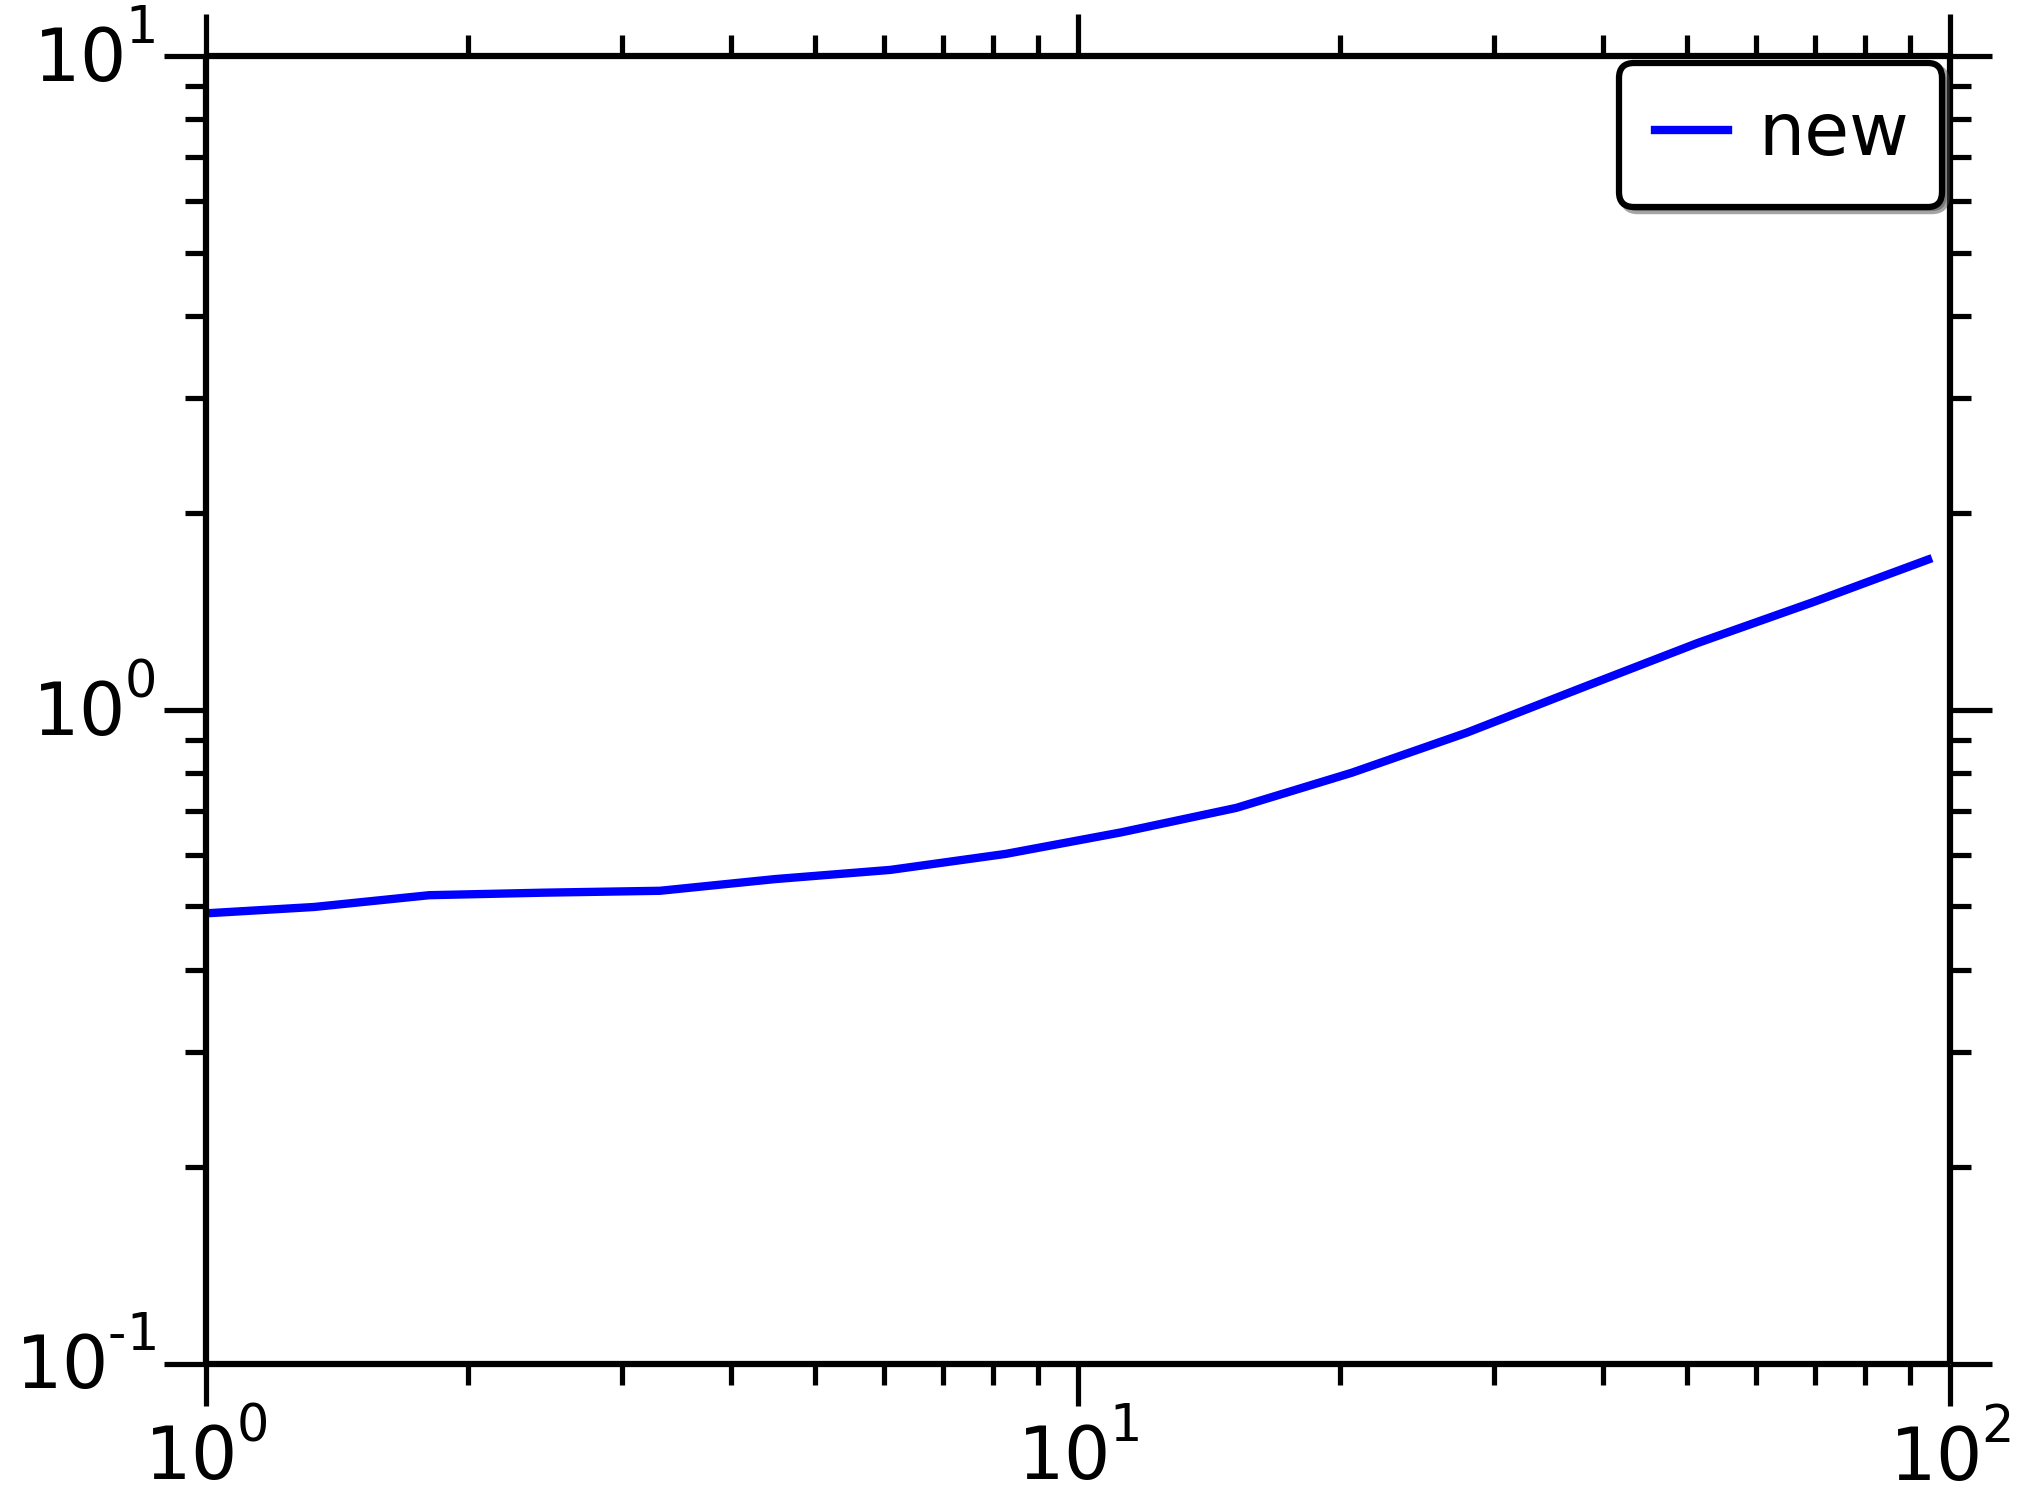

In [26]:
plot(r_re,r_re*errors,label='new')
#plot(error_qpm['rp'],error_qpm['rp']*error_qpm['DS_err_gR'])
xscale('log')
yscale('log')
legend()
xlim(1,100)